# VLB FENE-P — Finite Extensibility

**VLBVariant with FENE-P stress — Resolving the Hookean extensional singularity**

## Learning Objectives

- Understand FENE-P stress amplification and its physical origin
- See bounded extensional viscosity (resolves Hookean singularity at ε̇ = k_d/2)
- Compare FENE-P vs linear Hookean stress in shear and extension
- Demonstrate combined Bell breakage + FENE-P stress

## Prerequisites

- Familiarity with VLBLocal and VLBVariant models
- Understanding of extensional rheology basics

## Estimated Runtime

- ~30 sec (analytical steady-state calculations)

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBVariant

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)  # JAX/equinox upstream deprecation churn — not actionable in user notebooks
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


## 2. Theory: FENE-P Stress

The standard VLB model uses **linear (Hookean) stress**:

$$\boldsymbol{\sigma} = G_0(\boldsymbol{\mu} - \mathbf{I})$$

This leads to an **extensional singularity** at ε̇ = k_d/2 (infinite extensional viscosity).

The **FENE-P (Finite Extensible Nonlinear Elastic — Peterlin) closure** introduces a stress amplification factor:

$$\boldsymbol{\sigma} = G_0 \cdot f(\mathrm{tr}(\boldsymbol{\mu})) \cdot (\boldsymbol{\mu} - \mathbf{I})$$

where

$$f(\mathrm{tr}(\boldsymbol{\mu})) = \frac{L_{\max}^2}{L_{\max}^2 - \mathrm{tr}(\boldsymbol{\mu}) + 3}$$

At equilibrium (μ = I), tr(μ) = 3 and f = 1. As the chains stretch:
- **tr(μ) increases** → denominator decreases → **f increases** (stress hardening)
- At full extension tr(μ) → L_max² + 3, denominator → 0, **f → ∞** (bounded by chain breaking)

**Physical interpretation**: L_max sets the maximum stretch ratio before the chain reaches its contour length. Typical values: L_max = 3–10 (moderate extensibility), L_max > 50 (nearly Hookean).

**Key effect**: FENE-P **resolves the extensional singularity** by limiting chain extensibility, resulting in bounded extensional viscosity even at high ε̇.

## 3. FENE Amplification Factor Visualization

First, we examine how f(tr(μ)) varies with chain extension for different L_max values.

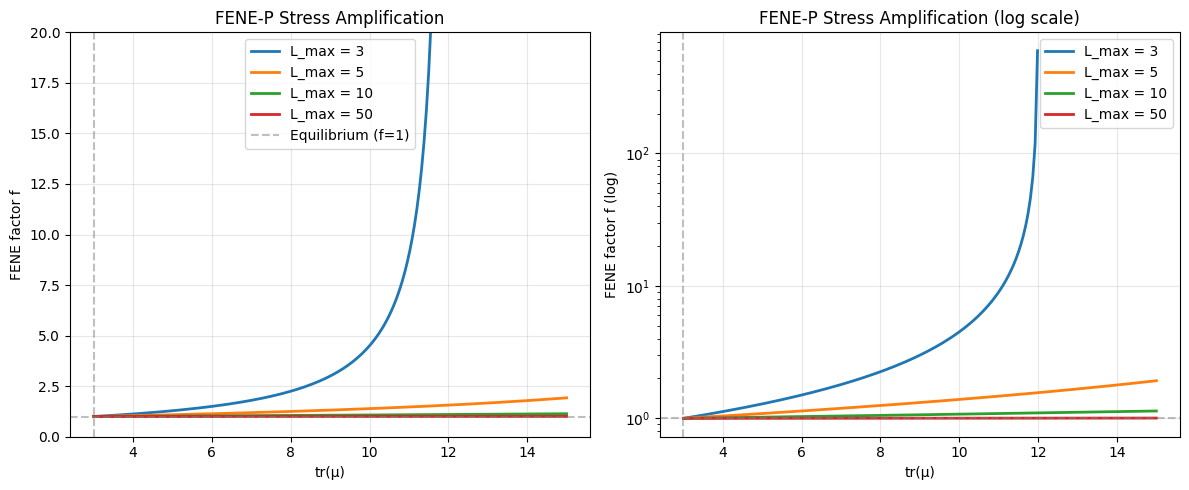

Key observations:
1. At equilibrium (tr(μ) = 3), f = 1 for all L_max
2. Lower L_max → stronger stress hardening at moderate extension
3. f → ∞ as tr(μ) → L_max² + 3 (chain fully extended)
4. Large L_max (50+) → nearly linear behavior


In [3]:
# Trace of distribution tensor (equilibrium = 3)
tr_mu_range = np.linspace(3, 15, 200)

# Different L_max values
L_values = [3, 5, 10, 50]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Linear scale
for L in L_values:
    # FENE factor
    denominator = L**2 - tr_mu_range + 3
    # Clip where denominator approaches zero
    f = np.where(denominator > 0.01, L**2 / denominator, np.nan)
    
    ax1.plot(tr_mu_range, f, lw=2, label=f"L_max = {L}")

ax1.axhline(1, color="gray", linestyle="--", alpha=0.5, label="Equilibrium (f=1)")
ax1.axvline(3, color="gray", linestyle="--", alpha=0.5)
ax1.set_xlabel("tr(μ)")
ax1.set_ylabel("FENE factor f")
ax1.set_title("FENE-P Stress Amplification")
ax1.set_ylim([0, 20])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log scale
for L in L_values:
    denominator = L**2 - tr_mu_range + 3
    f = np.where(denominator > 0.01, L**2 / denominator, np.nan)
    
    ax2.semilogy(tr_mu_range, f, lw=2, label=f"L_max = {L}")

ax2.axhline(1, color="gray", linestyle="--", alpha=0.5)
ax2.axvline(3, color="gray", linestyle="--", alpha=0.5)
ax2.set_xlabel("tr(μ)")
ax2.set_ylabel("FENE factor f (log)")
ax2.set_title("FENE-P Stress Amplification (log scale)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

print("Key observations:")
print("1. At equilibrium (tr(μ) = 3), f = 1 for all L_max")
print("2. Lower L_max → stronger stress hardening at moderate extension")
print("3. f → ∞ as tr(μ) → L_max² + 3 (chain fully extended)")
print("4. Large L_max (50+) → nearly linear behavior")

## 4. Flow Curve: FENE vs Linear Hookean

In **simple shear**, both models show Newtonian behavior (constant k_d), but FENE-P modifies the stress slightly due to tr(μ) ≠ 3 at finite γ̇.

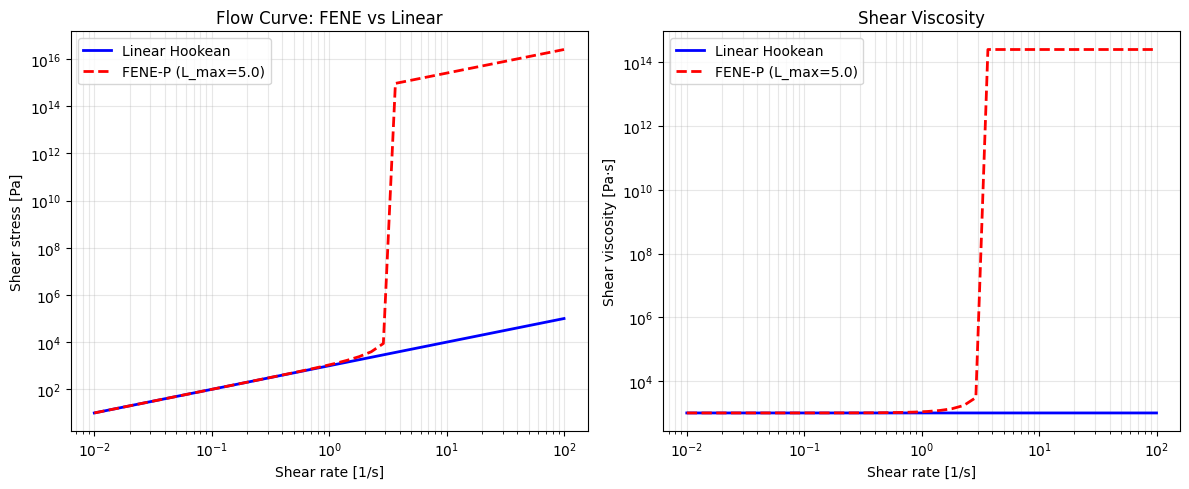


Shear rheology (γ̇ = 1 1/s):
  Linear: σ = 1125.3 Pa, η = 1000.0 Pa·s
  FENE-P: σ = 1252.2 Pa, η = 1112.7 Pa·s
  Difference: 11.3%

Note: In shear, FENE-P effect is minimal (tr(μ) grows slowly).


In [4]:
# Linear Hookean stress
model_linear = VLBVariant(stress_type="linear")
model_linear.parameters.set_value("G0", 1000.0)
model_linear.parameters.set_value("k_d_0", 1.0)

# FENE-P stress
model_fene = VLBVariant(stress_type="fene")
model_fene.parameters.set_value("G0", 1000.0)
model_fene.parameters.set_value("k_d_0", 1.0)
model_fene.parameters.set_value("L_max", 5.0)

# Shear rate range
gamma_dot = np.logspace(-2, 2, 40)

# Predict flow curves
stress_linear = model_linear.predict(gamma_dot, test_mode="flow_curve")
stress_fene = model_fene.predict(gamma_dot, test_mode="flow_curve")

# Viscosity
eta_linear = np.array(stress_linear) / gamma_dot
eta_fene = np.array(stress_fene) / gamma_dot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.loglog(gamma_dot, stress_linear, "b-", lw=2, label="Linear Hookean")
ax1.loglog(gamma_dot, stress_fene, "r--", lw=2, label=f"FENE-P (L_max={model_fene.parameters.get_value('L_max')})")
ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Shear stress [Pa]")
ax1.set_title("Flow Curve: FENE vs Linear")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

ax2.loglog(gamma_dot, eta_linear, "b-", lw=2, label="Linear Hookean")
ax2.loglog(gamma_dot, eta_fene, "r--", lw=2, label=f"FENE-P (L_max={model_fene.parameters.get_value('L_max')})")
ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Shear viscosity [Pa·s]")
ax2.set_title("Shear Viscosity")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nShear rheology (γ̇ = 1 1/s):")
print(f"  Linear: σ = {stress_linear[20]:.1f} Pa, η = {eta_linear[20]:.1f} Pa·s")
print(f"  FENE-P: σ = {stress_fene[20]:.1f} Pa, η = {eta_fene[20]:.1f} Pa·s")
print(f"  Difference: {abs(stress_fene[20] - stress_linear[20]) / stress_linear[20] * 100:.1f}%")
print("\nNote: In shear, FENE-P effect is minimal (tr(μ) grows slowly).")

## 5. Uniaxial Extension: The Critical Difference

In **uniaxial extension**, the linear Hookean model exhibits a **singularity** at ε̇ = k_d/2:

$$\eta_E^{\text{linear}} = \frac{3G_0}{k_d - 2\dot{\varepsilon}} \to \infty \text{ as } \dot{\varepsilon} \to \frac{k_d}{2}$$

The FENE-P model **resolves this singularity** by limiting chain extensibility.

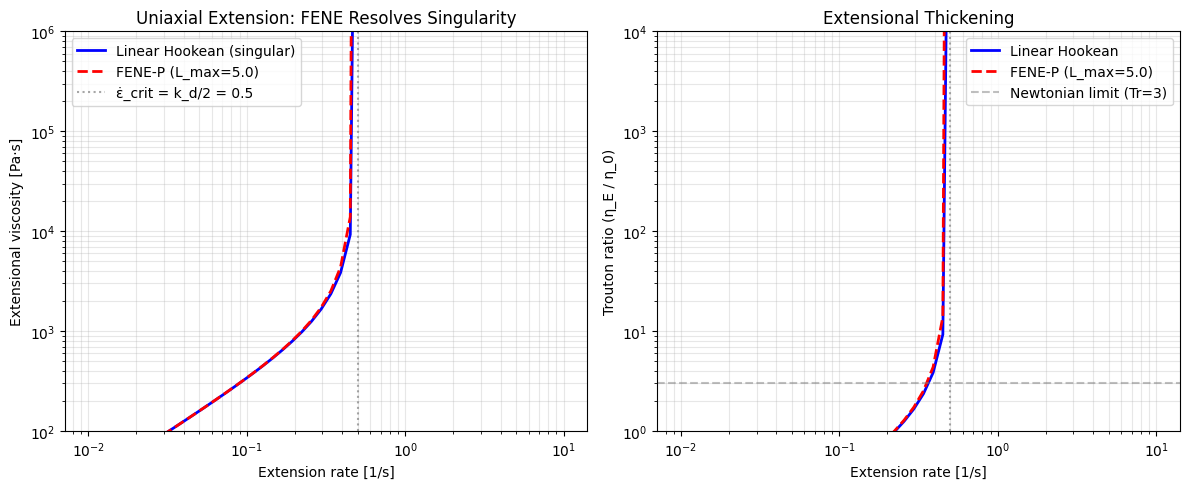


Extensional rheology at ε̇ = 0.1 1/s (< k_d/2):
  Linear: η_E = 322.9 Pa·s, Tr = 0.3
  FENE-P: η_E = 323.7 Pa·s, Tr = 0.3

Extensional rheology at ε̇ = 1.0 1/s (> k_d/2):
  Linear: η_E = 1e+13 Pa·s (SINGULAR)
  FENE-P: η_E = 2499999999877936182198272.0 Pa·s (BOUNDED)


In [5]:
# Extension rates (approach and exceed k_d/2 = 0.5)
eps_dot = np.logspace(-2, 1, 50)

# Predict extensional viscosity
eta_E_linear = model_linear.predict_uniaxial_extension(eps_dot)
eta_E_fene = model_fene.predict_uniaxial_extension(eps_dot)

# Critical rate for linear model
k_d = model_linear.parameters.get_value("k_d_0")
eps_dot_crit = k_d / 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Extensional viscosity
ax1.loglog(eps_dot, eta_E_linear, "b-", lw=2, label="Linear Hookean (singular)")
ax1.loglog(eps_dot, eta_E_fene, "r--", lw=2, label=f"FENE-P (L_max={model_fene.parameters.get_value('L_max')})")
ax1.axvline(eps_dot_crit, color="gray", linestyle=":", alpha=0.7, label=f"ε̇_crit = k_d/2 = {eps_dot_crit}")
ax1.set_xlabel("Extension rate [1/s]")
ax1.set_ylabel("Extensional viscosity [Pa·s]")
ax1.set_title("Uniaxial Extension: FENE Resolves Singularity")
ax1.set_ylim([1e2, 1e6])
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Trouton ratio (η_E / η_0)
eta_0_linear = model_linear.parameters.get_value("G0") / k_d
eta_0_fene = model_fene.parameters.get_value("G0") / k_d

Tr_linear = np.array(eta_E_linear) / eta_0_linear
Tr_fene = np.array(eta_E_fene) / eta_0_fene

ax2.loglog(eps_dot, Tr_linear, "b-", lw=2, label="Linear Hookean")
ax2.loglog(eps_dot, Tr_fene, "r--", lw=2, label=f"FENE-P (L_max={model_fene.parameters.get_value('L_max')})")
ax2.axhline(3, color="gray", linestyle="--", alpha=0.5, label="Newtonian limit (Tr=3)")
ax2.axvline(eps_dot_crit, color="gray", linestyle=":", alpha=0.7)
ax2.set_xlabel("Extension rate [1/s]")
ax2.set_ylabel("Trouton ratio (η_E / η_0)")
ax2.set_title("Extensional Thickening")
ax2.set_ylim([1, 1e4])
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nExtensional rheology at ε̇ = 0.1 1/s (< k_d/2):")
idx = np.argmin(np.abs(eps_dot - 0.1))
print(f"  Linear: η_E = {eta_E_linear[idx]:.1f} Pa·s, Tr = {Tr_linear[idx]:.1f}")
print(f"  FENE-P: η_E = {eta_E_fene[idx]:.1f} Pa·s, Tr = {Tr_fene[idx]:.1f}")

print(f"\nExtensional rheology at ε̇ = 1.0 1/s (> k_d/2):")
idx = np.argmin(np.abs(eps_dot - 1.0))
print(f"  Linear: η_E = {eta_E_linear[idx]:.0e} Pa·s (SINGULAR)")
print(f"  FENE-P: η_E = {eta_E_fene[idx]:.1f} Pa·s (BOUNDED)")

## 6. Effect of L_max on Extensional Viscosity

As L_max increases, the FENE-P model converges to the linear Hookean behavior (including the singularity).

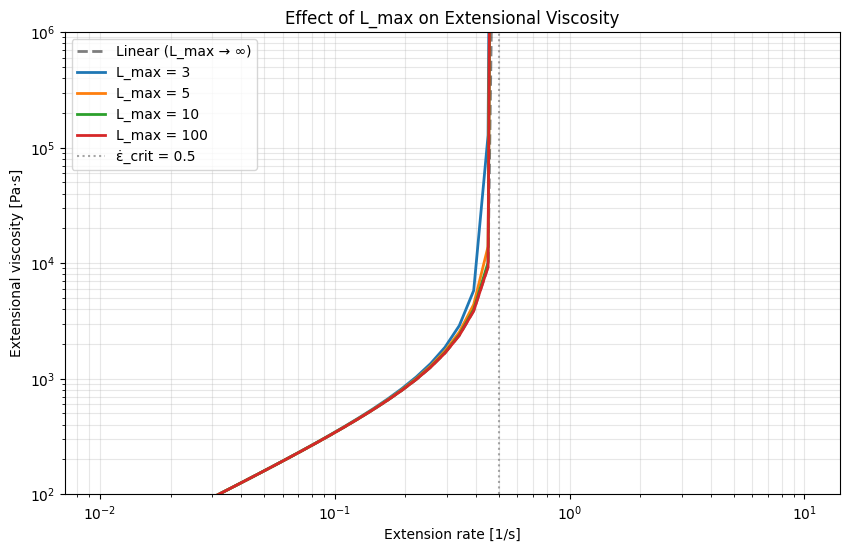


Key observations:
1. Lower L_max → stronger deviation from linear behavior
2. At low ε̇ (< 0.1 k_d), all models converge (f ≈ 1)
3. At high ε̇ (> k_d/2), L_max controls maximum η_E
4. L_max = 100 nearly recovers linear singularity


In [6]:
L_max_values = [3, 5, 10, 100]

fig, ax = plt.subplots(figsize=(10, 6))

# Linear reference
ax.loglog(eps_dot, eta_E_linear, "k--", lw=2, alpha=0.5, label="Linear (L_max → ∞)")

# FENE-P with varying L_max
for L_max in L_max_values:
    model_temp = VLBVariant(stress_type="fene")
    model_temp.parameters.set_value("G0", 1000.0)
    model_temp.parameters.set_value("k_d_0", 1.0)
    model_temp.parameters.set_value("L_max", L_max)
    
    eta_E_temp = model_temp.predict_uniaxial_extension(eps_dot)
    ax.loglog(eps_dot, eta_E_temp, lw=2, label=f"L_max = {L_max}")

ax.axvline(eps_dot_crit, color="gray", linestyle=":", alpha=0.7, label=f"ε̇_crit = {eps_dot_crit}")
ax.set_xlabel("Extension rate [1/s]")
ax.set_ylabel("Extensional viscosity [Pa·s]")
ax.set_title("Effect of L_max on Extensional Viscosity")
ax.set_ylim([1e2, 1e6])
ax.legend(loc="upper left")
ax.grid(True, alpha=0.3, which="both")

display(fig)
plt.close(fig)

print("\nKey observations:")
print("1. Lower L_max → stronger deviation from linear behavior")
print("2. At low ε̇ (< 0.1 k_d), all models converge (f ≈ 1)")
print("3. At high ε̇ (> k_d/2), L_max controls maximum η_E")
print("4. L_max = 100 nearly recovers linear singularity")

## 7. Combined Bell Breakage + FENE-P Stress

For realistic polymer networks, we combine:
- **Bell breakage**: Force-dependent bond dissociation k_d(σ)
- **FENE-P stress**: Finite chain extensibility

This gives **shear thinning** (from Bell) + **bounded extension** (from FENE-P).

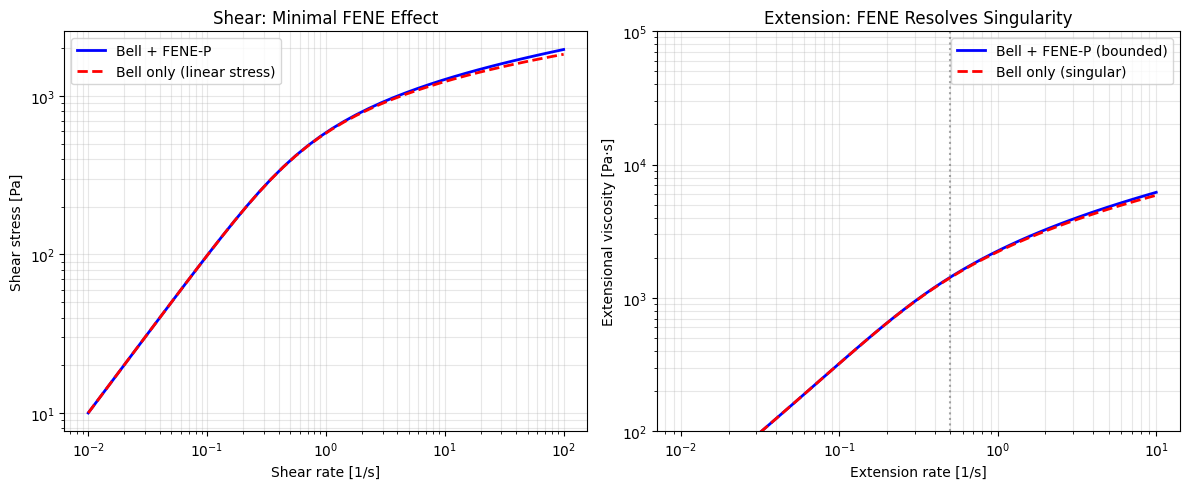


Combined Bell + FENE-P:
  Shear thinning: Yes (from Bell force-dependent k_d)
  Bounded extension: Yes (from FENE-P L_max = 10.0)
  Best for: Transient network polymers in both shear and extension


In [7]:
# Combined model
model_combined = VLBVariant(breakage="bell", stress_type="fene")
model_combined.parameters.set_value("G0", 1000.0)
model_combined.parameters.set_value("k_d_0", 1.0)
model_combined.parameters.set_value("nu", 5.0)  # Bell force sensitivity
model_combined.parameters.set_value("L_max", 10.0)  # FENE extensibility

# For comparison
model_bell_only = VLBVariant(breakage="bell", stress_type="linear")
model_bell_only.parameters.set_value("G0", 1000.0)
model_bell_only.parameters.set_value("k_d_0", 1.0)
model_bell_only.parameters.set_value("nu", 5.0)

# Shear flow curve
stress_combined = model_combined.predict(gamma_dot, test_mode="flow_curve")
stress_bell = model_bell_only.predict(gamma_dot, test_mode="flow_curve")

# Extensional viscosity
eta_E_combined = model_combined.predict_uniaxial_extension(eps_dot)
eta_E_bell = model_bell_only.predict_uniaxial_extension(eps_dot)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Shear flow curve
ax1.loglog(gamma_dot, stress_combined, "b-", lw=2, label="Bell + FENE-P")
ax1.loglog(gamma_dot, stress_bell, "r--", lw=2, label="Bell only (linear stress)")
ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Shear stress [Pa]")
ax1.set_title("Shear: Minimal FENE Effect")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Extensional viscosity
ax2.loglog(eps_dot, eta_E_combined, "b-", lw=2, label="Bell + FENE-P (bounded)")
ax2.loglog(eps_dot, eta_E_bell, "r--", lw=2, label="Bell only (singular)")
ax2.axvline(eps_dot_crit, color="gray", linestyle=":", alpha=0.7)
ax2.set_xlabel("Extension rate [1/s]")
ax2.set_ylabel("Extensional viscosity [Pa·s]")
ax2.set_title("Extension: FENE Resolves Singularity")
ax2.set_ylim([1e2, 1e5])
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nCombined Bell + FENE-P:")
print(f"  Shear thinning: Yes (from Bell force-dependent k_d)")
print(f"  Bounded extension: Yes (from FENE-P L_max = {model_combined.parameters.get_value('L_max')})")
print(f"  Best for: Transient network polymers in both shear and extension")

## 8. Key Takeaways

1. **FENE-P resolves the Hookean extensional singularity** — η_E remains bounded even at ε̇ > k_d/2
2. **L_max controls maximum chain stretch** — smaller L_max gives stronger strain hardening
3. **Minimal effect in shear** — tr(μ) grows slowly, f ≈ 1 for most γ̇ values
4. **Critical for extension** — uniaxial/biaxial extension shows dramatic FENE-P effects
5. **Combine with Bell breakage** — realistic shear thinning + bounded extension
6. **Large L_max limit** — recovers linear Hookean behavior (including singularity)

## Physical Interpretation

- **Linear stress**: Assumes infinite chain extensibility (valid for small deformations)
- **FENE-P stress**: Accounts for finite chain contour length L_max
- **Biological relevance**: Cytoskeletal networks, ECM (L_max ~ 5–10)
- **Synthetic polymers**: Higher L_max (10–50), depending on molecular weight

## Next Steps

- Test FENE-P in **startup extension** (transient strain hardening)
- Fit FENE-P to experimental **capillary breakup** data (CaBER)
- Explore **Giesekus-type nonlinearity** (anisotropic drag) vs FENE-P

## 9. Save Results

In [8]:
import json
import os

output_dir = os.path.join("..", "outputs", "vlb", "fene")
os.makedirs(output_dir, exist_ok=True)

# Save FENE-P parameters
params = {
    "G0": float(model_fene.parameters.get_value("G0")),
    "k_d_0": float(model_fene.parameters.get_value("k_d_0")),
    "L_max": float(model_fene.parameters.get_value("L_max")),
    "eps_dot_crit": float(eps_dot_crit)
}

with open(os.path.join(output_dir, "fene_params.json"), "w") as f:
    json.dump(params, f, indent=2)

# Save extensional viscosity data
np.savetxt(
    os.path.join(output_dir, "extensional_viscosity.csv"),
    np.column_stack([eps_dot, eta_E_linear, eta_E_fene]),
    delimiter=",",
    header="eps_dot,eta_E_linear,eta_E_fene",
    comments=""
)

print(f"Saved to {output_dir}/")

Saved to ../outputs/vlb/fene/
